# An Exploration of Image Similarity Metrics for Edge Image Reconstruction

Before we can go about using generative AI to reduce ingress bandwidth for images transferred over the internet, we need a robust metric for comparing the similarity of images pre and post reconstruction. This will allow us to explore the bandwidth-similarity tradeoff when reconstructing images over a network. This notebook explores three such similarity metrics. Each metric is explored in two cases where images are perceptually similar and one case where they are dissimilar so that their results can be observed in both possibilities. The perceptually similar images were recreated using Stable Diffusion leveraging Canny Edge detection, which allows the model to explicitly know the outlines and the general structure of objects in the image.

<p float="left">
  <img src="./examples/bird_input.png" width="400" />
  <img src="./examples/bird_canny.png" width="400" /> 
</p>

## Basic Image Similartiy Metrics

PSNR, SSIM, and FSIM are fundamental image similarity metrics focusing on pixel-level differences.

* PSNR (Peak Signal-to-Noise Ratio) measures the ratio between the maximum possible intensity and the distortion; it's commonly used to assess the quality of reconstruction or compression.
* SSIM (Structural Similarity Index Measure) evaluates image quality by comparing changes in structural information, brightness, and contrast.
* FSIM (Feature Similarity Index Measure) goes a step further by considering phase congruency and gradient magnitude to assess similarity, providing a more nuanced view than mere pixel intensity differences. 

Despite their differences, all three metrics provide a basic yet effective means of evaluating image similarity by scrutinizing the direct pixel-wise discrepancies.

In [2]:
from image_similarity_measures.evaluate import evaluation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
def drawImage(filepath, title):
    image = mpimg.imread(filepath)
    plt.imshow(image)
    plt.title(title)
    plt.show()

def drawImages(filepath1, title1, filepath2, title2):
    _, axarr = plt.subplots(1,2, figsize=(9, 9))
    axarr[0].imshow(mpimg.imread(filepath1))
    axarr[0].set_title(title1)
    axarr[0].axis('off')
    axarr[1].imshow(mpimg.imread(filepath2))
    axarr[1].set_title(title2)
    axarr[1].axis('off')
    plt.plot()

{'psnr': 36.00773304079643,
 'ssim': 0.8279766208599605,
 'fsim': 0.3501404298215653}

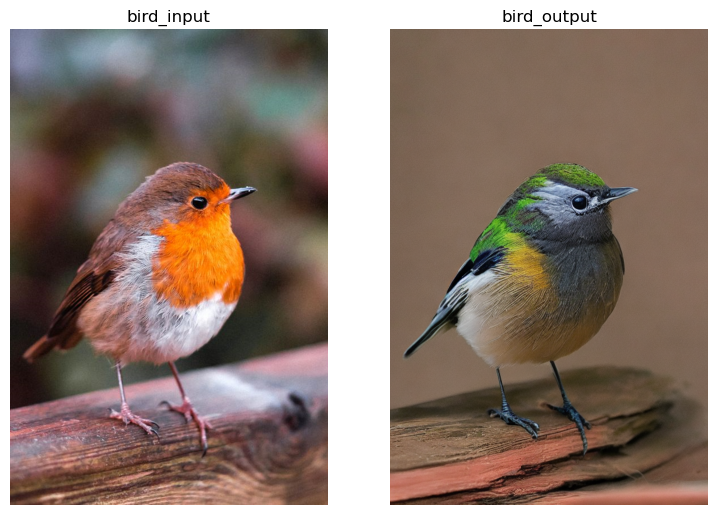

In [6]:
drawImages('./examples/bird_input.png', "bird_input", './examples/bird_output.png', "bird_output")
evaluation(org_img_path='./examples/bird_input.png', 
           pred_img_path='./examples/bird_output.png', 
           metrics=["psnr", "ssim", "fsim"])

{'psnr': 33.58061734566728,
 'ssim': 0.8222724669477358,
 'fsim': 0.3252802269283752}

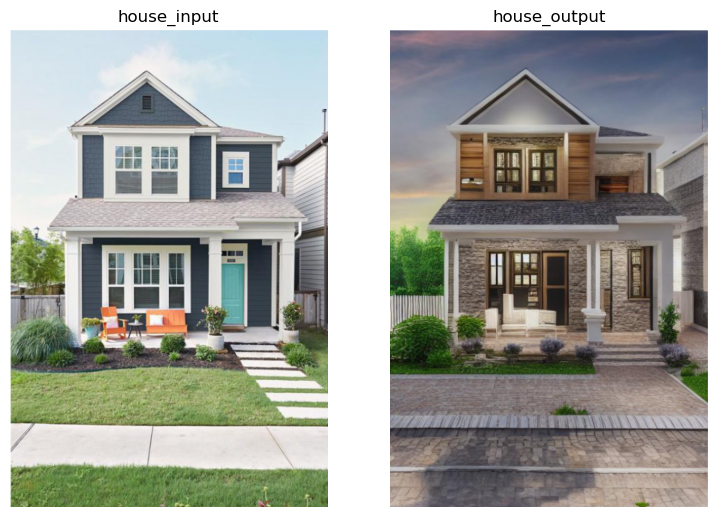

In [8]:
drawImages('./examples/house_input.png', "house_input", './examples/house_output.png', "house_output")
evaluation(org_img_path='./examples/house_input.png', 
           pred_img_path='./examples/house_output.png', 
           metrics=["psnr", "ssim", "fsim"])

{'psnr': 30.47242614234659,
 'ssim': 0.6297982322781664,
 'fsim': 0.23640050029105408}

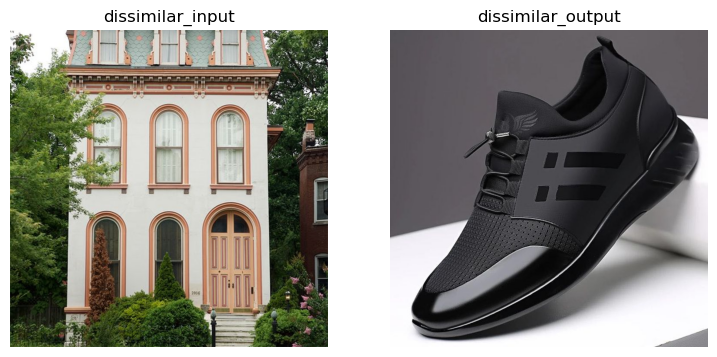

In [10]:
drawImages('./examples/dissimilar_input.png', "dissimilar_input", './examples/dissimilar_output.png', "dissimilar_output")
evaluation(org_img_path='./examples/dissimilar_input.png', 
           pred_img_path='./examples/dissimilar_output.png', 
           metrics=["psnr", "ssim", "fsim"])

Let's explore each metric individually:

* PSNR returns similar values both when the images are similar and dissimilar

* SSIM is normalized between 0 and 1. It returns high values when the images are similar and lower values when they are not, although the difference between the two cases is still not as stark.

* FSIM is also normalized between 0 and 1. We see a similar trend in FSIM values when comparing to SSIM although the absolute numbers are significantly lower in all cases.

Overall, due to marginal differences in SSIM and FSIM values when comparing across similar and dissimilar images, we conclude that these metrics will not be meaningful in quantifying the edge reconstructed images as 'perceptually similar' or 'not perceptually similar', therefore we need to explore further.

## SIFT Image Similarity Algorithm

The SIFT (Scale-Invariant Feature Transform) algorithm is a computer vision technique used for feature detection and description. SIFT works by identifying distinct keypoints in an image based on their local intensity extrema and computing descriptors that capture the local image information around those key points. These descriptors can then be used for tasks like image matching, object recognition, and image retrieval.

The keypoints essentially capture local features of an image that are robust to changes in scale, rotation, and affine transformations. Thus the SIFT algorithm may work better in our case, where pairs of images may have differences yet are still perceptually similar.

In [2]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

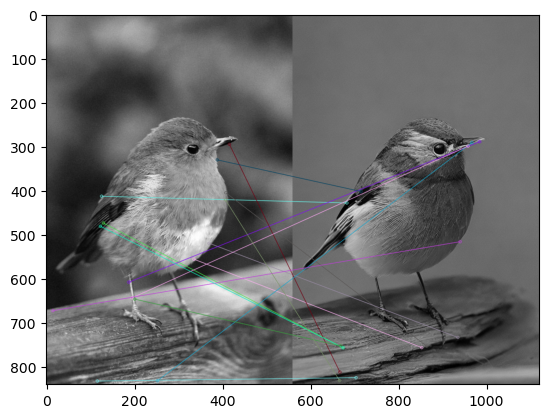

(<matplotlib.image.AxesImage at 0x1af485c6a10>, None)

In [19]:
# read images
img1 = cv2.imread('./data/images/bird_input.png')  
img2 = cv2.imread('./data/images/bird_output.png') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:15], img2, flags=2)
plt.imshow(img3),plt.show()

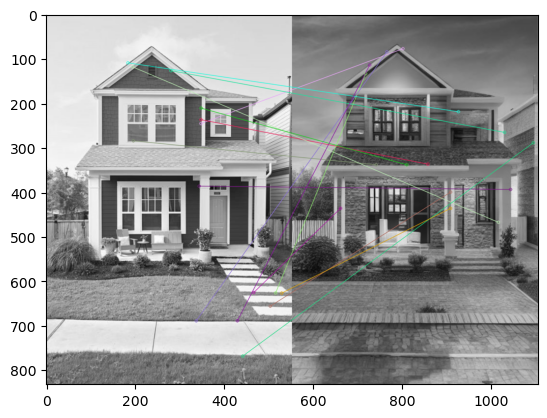

(<matplotlib.image.AxesImage at 0x19029a38a90>, None)

In [3]:
# read images
img1 = cv2.imread('./data/images/house_input.png')  
img2 = cv2.imread('./data/images/house_output.png') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:15], img2, flags=2)
plt.imshow(img3),plt.show()

However, it turns out that the keypoint mapping between similar images is actually quite poor. This is because SIFT works well in contexts where the two images capture a subject that is identical or close to identical. Even though both these images are of the same type of bird in the same position, at the pixel level their features are significantly different due to Stable Diffusion 'filling in' the Canny edges with what it thinks is appropriate. Hence, SIFT struggles with accurately finding common, locally similar keypoints between perceptually similar images.

## Similarity Comparison using VGG16 Deep Learning

It is clear that if we want to determine if two images are similar or non-similar, we need to somehow extract semantics from an image rather than looking at pixel based approaches. This is where VGG models come in.

The VGG model, specifically the VGG16 and VGG19 versions, is a significant advancement in the field of computer vision, known for its simplicity and depth. VGG16 and VGG19 refer to VGG models with 16 and 19 layers deep, respectively. By using this model, we can extract high-level features from different images and compare them to identify similarities.  These models are characterized by their use of very small (3x3) convolution filters throughout the network, which allowed the researchers to build deeper networks that could capture more complex features at various scales and improve the accuracy in large-scale image recognition tasks.

We can employ VGG16 in the previous test case and see the results:

In [1]:
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [5]:
vgg16 = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

# Freezing the layers
for model_layer in vgg16.layers:
    model_layer.trainable = False

In [32]:
def load_and_preprocess_image(image_path):
    """
    Load and preprocess an image for the VGG16 model.
    """
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

def get_image_embeddings(img_array):
    """
    Get image embeddings using the VGG16 model.
    """
    return vgg16.predict(img_array)

def get_similarity_score(first_image_path, second_image_path):
    """
    Compute the similarity score between two images.
    """
    first_image_array = load_and_preprocess_image(first_image_path)
    second_image_array = load_and_preprocess_image(second_image_path)
    first_image_embedding = get_image_embeddings(first_image_array)
    second_image_embedding = get_image_embeddings(second_image_array)
    return cosine_similarity(first_image_embedding, second_image_embedding)[0][0]

def draw_images(*image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(8, 8))
    for ax, image_path in zip(axes, image_paths):
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

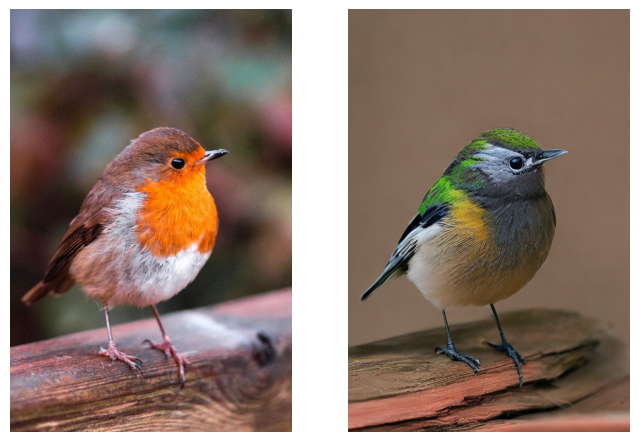

1/1 [==============================] - 0s 111ms/step
Similarity Score: 0.7693008780479431


In [33]:
bird_input = './examples/bird_input.png'
bird_output = './examples/bird_output.png'

draw_images(bird_input, bird_output)
similarity_score = get_similarity_score(bird_input, bird_output)
print(f"Similarity Score: {similarity_score}")

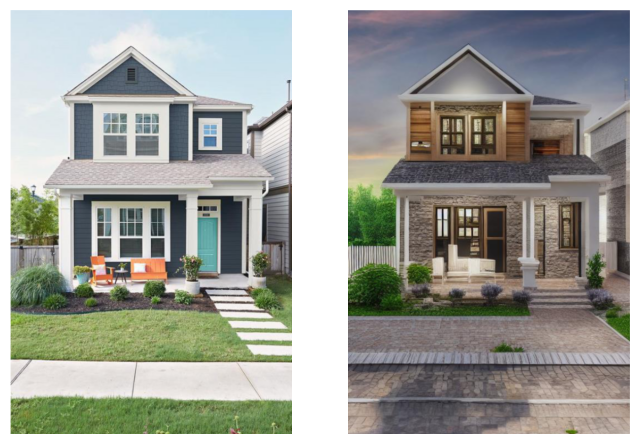

1/1 [==============================] - 0s 103ms/step
Similarity Score: 0.7436819076538086


In [34]:
house_input = './examples/house_input.png'
house_output = './examples/house_output.png'

draw_images(house_input, house_output)
similarity_score = get_similarity_score(house_input, house_output)
print(f"Similarity Score: {similarity_score}")

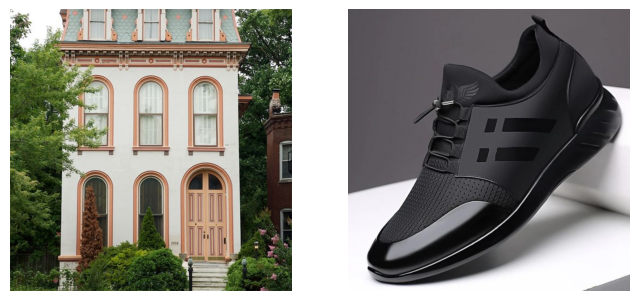

1/1 [==============================] - 0s 93ms/step
Similarity Score: 0.3142552077770233


In [35]:
dissimilar_input = './examples/dissimilar_input.png'
dissimilar_output = './examples/dissimilar_output.png'

draw_images(dissimilar_input, dissimilar_output)
similarity_score = get_similarity_score(dissimilar_input, dissimilar_output)
print(f"Similarity Score: {similarity_score}")

As evident, the VGG16 model outputs a high cosine similarity score for reconstructed perceptually similar images and a low similarity score in the dissimilar case, thus it can be used as a valid metric for our research task in exploring the bandwidth-similarity tradeoff. Furthermore, due to the model's simplicity at every convolutional layer, the processing times are extremely low, leaving plenty of room to increase the model's parameters and/or upgrade to VGG19 to perhaps get even better results while still keeping the processing time fairly reasonable for a large dataset.